# 1. The dataset

We downloaded a dump of the https://philosophy.stackexchange.com website from https://archive.org/download/stackexchange/philosophy.stackexchange.com.7z. This dump contains xml files for posts, comments, tags, etc. (see the readme included in the archive for the details). To keep our model simple, we only used the posts data available in the `Posts.xml` file. This consists of individual post records including information such as the post's id, the accepted answer's id and of course the text of the question or answer. The former can be distinguished from the latter by the `PostTypeId` attribute, which is set to 1 for questions, and 2 for answers.

This part of the notebook parses the xml file and convert its content to the csv format, so that it can be more easily be manipulated through pandas.

In [1]:
#!/usr/bin/env python3
# -*- python -*-

import csv
import numpy as np
import pandas as pd
import html as parser
import matplotlib.pyplot as plt

from xml.etree import cElementTree
from html.parser import HTMLParser
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [184]:
class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def handle_starttag(self, tag, attrs):
        if tag == 'a':
            link = [value + ' ' for name,value in attrs if name == 'href']
            self.fed.extend(link)
    def get_data(self):
        return ''.join(self.fed)

# Copy/paste from the help section on SEDE
# http://data.stackexchange.com/stackoverflow/query/new
def get_schema():
    schema = {
        'Id':                    np.uint,
        'PostTypeId':            np.uint8,
        'AcceptedAnswerId':      np.uint,
        'ParentId':              np.uint,
        'CreationDate':          np.str,
        'DeletionDate':          np.str,
        'Score':                 np.int,
        'ViewCount':             np.uint,
        'Body':                  np.str,
        'OwnerUserId':           np.uint,
        'OwnerDisplayName':      np.str,
        'LastEditorUserId':      np.uint,
        'LastEditorDisplayName': np.str,
        'LastEditDate':          np.str,
        'LastActivityDate':      np.str,
        'Title':                 np.str,
        'Tags':                  np.str,
        'AnswerCount':           np.uint,
        'CommentCount':          np.uint,
        'FavoriteCount':         np.uint,
        'ClosedDate':            np.str,
        'CommunityOwnedDate':    np.str,
    }
    return schema


def dump(fh):
    """
    Read a stream from FH, yield next Post row
    """
    schema = get_schema()
    events = cElementTree.iterparse(fh)
    for event, elem in events:
        if elem.tag != 'row':
            continue
        result = []
        for key, dtype in schema.items():
            try:
                result.append(elem.attrib[key])
            except KeyError:
                if dtype in [np.int, np.uint, np.uint8]:
                    result.append('0')
                elif 'date' in key.lower():
                    result.append('1970-01-01T00:00:00.000')
                else:
                    result.append('EMP') # handle empty strings to prevent NaNs
        yield result
        elem.clear()

def parse_to_csv(infile='data/Posts.xml', outfile='data/posts.csv'):
    with open(infile, encoding='utf-8') as infile:
        writer = csv.writer(open(outfile, 'w', encoding='utf-8'))
        
        cnt = 0
        # write cols names first
        writer.writerow(get_schema().keys())
        for line in dump(infile):
            writer.writerow(line)
            cnt += 1
            
    print('Processed {} lines'.format(cnt))
    

In [2]:
parse_to_csv()

Processed 32830 lines


# 2. Preprocessing

In this section of the notebook we deal with a first preprocessing of the dataset in order to extract the most meaningful information for the task. In particular, as we are interested in question-answering chatbot, we need to associate each question with the accepted answer, if any, or the one with the highest vote count otherwise. In this way, we can filter a bit of the noise we can expect in many answers, especially for such a subject as philosophy. We decided to keep html urls in the text, as these are usually important part of the answer, pointing the user to useful external information.

In [4]:
def strip_tags(html):
    html = parser.unescape(html)
    s = MLStripper()
    s.feed(html)
    return s.get_data()

def read_data(infile='data/posts.csv'):
    df = pd.read_csv(infile, encoding='utf-8')
    df = df.astype(dtype=get_schema())
    return df

def parse_data(df):
    """
    Parse the input data, removing html tags
    """
    df['Body'] = df['Body'].apply(lambda body: strip_tags(body))
    return df

In [185]:
raw_df = read_data()
print(raw_df.columns)

Index(['Id', 'PostTypeId', 'AcceptedAnswerId', 'ParentId', 'CreationDate',
       'DeletionDate', 'Score', 'ViewCount', 'Body', 'OwnerUserId',
       'OwnerDisplayName', 'LastEditorUserId', 'LastEditorDisplayName',
       'LastEditDate', 'LastActivityDate', 'Title', 'Tags', 'AnswerCount',
       'CommentCount', 'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate'],
      dtype='object')


In [186]:
# get rid of data we don't need
df = parse_data(raw_df)
df.loc[df['Title'] != 'EMP','Body'] = df['Title'] + '. ' + df['Body']
df = df.replace('EMP', '')
df = df[['Id', 'PostTypeId', 'ParentId', 'AcceptedAnswerId', 'Score', 'Body', 'Tags']]
df.head(10)

,Id,PostTypeId,ParentId,AcceptedAnswerId,Score,Body,Tags
0,1,1,0,4,161,Was mathematics invented or discovered?. What ...,<epistemology><ontology><philosophy-of-mathema...
1,3,1,0,31,6,"If you kill someone who is committing suicide,...",<ethics>
2,4,2,1,0,109,"""http://en.wikipedia.org/wiki/Intuitionism Int...",
3,6,1,0,13,20,Is atheism a requirement for a consistent exis...,<existentialism><kierkegaard><atheism><sartre>...
4,8,1,0,0,6,"If we value free agency, how can punishment - ...",<state>
5,9,2,6,0,7,An existentialist philosophy is nothing more t...,
6,10,2,1,0,6,Mathematics is an abstraction. As such it is i...,
7,11,2,6,0,7,"God is negotiable under existential tenets, as...",
8,12,1,0,0,16,What's the difference between Randian philosop...,<ayn-rand><objectivism>
9,13,2,6,0,16,Perhaps a better question to ask is the invers...,


In this part, we try to associate each question with its accepted answer, if any is marked as such, or the answer with the highest votes count, if any.

In [235]:
# some preprocessing to match questions with best answers
question_no_answer = df[(df['PostTypeId'] == 1) & (df['AcceptedAnswerId'] == 0)]
question_with_answer = df[(df['PostTypeId'] == 1) & (df['AcceptedAnswerId'] > 0)]
accepted_answer = df[(df['PostTypeId'] == 2) & (df['ParentId'].isin(question_with_answer['Id']))]
answer = df[(df['PostTypeId'] == 2) & (~df.index.isin(accepted_answer.index))]
answer = answer.sort_values(['ParentId', 'Score'], ascending=[True,False]).groupby(['ParentId']).first().reset_index()

In [237]:
question_with_answer = pd.merge(question_with_answer, accepted_answer, left_on='AcceptedAnswerId', right_on='Id', how='left', suffixes=['_q','_a'])
question_no_answer = pd.merge(question_no_answer, answer, left_on='Id', right_on='ParentId', how='left', suffixes=['_q','_a'])

In [356]:
# Again, only keep columns we need
final_df = pd.concat([question_with_answer, question_no_answer]).reset_index()
final_df = final_df[['Id_q', 'Body_q', 'Id_a', 'Body_a']]

In [239]:
# just save everything in one big text file
with open('data/posts.txt', 'w', encoding='utf-8') as outfile:
    for bq, ba in zip(final_df['Body_q'], final_df['Body_a']): 
        outfile.write(u'{}'.format(bq))
        outfile.write(u'{}'.format(ba))
#         break

## 2.1 word2vec tag-based clustering of questions
Having only one big network doing all the heavylift is probably going to perform pretty bad. After all, it's just appending random words one after another, with no knowledge of the topic of the discussion! One solution could be to use word2vec (or glove) word vectors to cluster questions by topic. A bunch of networks could then be trained on the different topics. So let's try to use the tags for the clustering...

In [2]:
def plot_distance_matrix(distance_matrix, labels):
    n = distance_matrix.shape[0]   
    plt.figure(figsize=(20,10))
    plt.imshow(distance_matrix, cmap='Blues')
    plt.xticks(range(n), labels, rotation=90)
    plt.yticks(range(n), labels)
    plt.colorbar()
    plt.show()
    
def plot_dendrogram(model, **kwargs):
    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    plt.figure(figsize=(10,5))
    dendrogram(linkage_matrix, **kwargs)
    plt.show()


In [241]:
import re

# check for unique tags
unique_tags = set(['none'])
for question_tags in df['Tags'].unique():
    tags = re.findall('<([a-zA-Z-]+)>', question_tags)
    unique_tags = unique_tags.union(set(tags))
    
unique_tags = sorted(list(unique_tags))
unique_tags

['abortion',
 'abstract',
 'absurdism',
 'adorno',
 'aesthetics',
 'affect',
 'agnosticism',
 'alienation',
 'altruism',
 'analogy',
 'analytic-philosophy',
 'analytic-synthetic-divide',
 'analyticity',
 'ancient',
 'ancient-philosophy',
 'animal-welfare',
 'animals',
 'anselm',
 'anthropology',
 'anti-realism',
 'applied-philosophy',
 'aquinas',
 'arendt',
 'argumentation',
 'aristotle',
 'arithmetic',
 'art',
 'artifact',
 'artificial-intelligence',
 'atheism',
 'atomism',
 'attitude',
 'authenticity',
 'awareness',
 'axiology',
 'ayn-rand',
 'badiou',
 'beauty',
 'being-and-time',
 'belief',
 'benjamin',
 'berkeley',
 'bertrand-russell',
 'bioethics',
 'bostrom',
 'brain-in-a-vat',
 'buddhism',
 'camus',
 'capitalism',
 'cassirer',
 'categorical-framework',
 'categorical-imperative',
 'causality',
 'causation',
 'charity',
 'charles-taylor',
 'chinese-philosophy',
 'chomsky',
 'christianity',
 'cicero',
 'classification',
 'cloning',
 'cognitive-psychology',
 'cognitive-sciences',
 

In [242]:
# import glove vectors to compute similarity between tags
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors

glove_input_file = 'data/glove.6B.300d.txt'
word2vec_output_file = 'data/glove.6B.300d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False) # './GoogleNews-vectors-negative300.bin'

In [263]:
from nltk.corpus import stopwords

sw = set(stopwords.words('english'))
split_tags = [[tag for tag in ctag.split('-') if tag not in sw] for ctag in unique_tags]

bad_tags = [tag for ctag in split_tags for tag in ctag if tag not in model] # tags which do not appear in the vector model
good_tags = [[tag for tag in ctag if tag not in bad_tags] for ctag in split_tags]
good_tags = [tag for tag in good_tags if len(tag) > 0]

In [264]:
print('--> Bad tags:\n', bad_tags)
print('\n--> Good tags:\n', good_tags)

--> Bad tags:
 ['axiology', 'compatibilism', 'critque', 'dialetheism', 'goedel', 'holderlin', 'korsgaard', 'lucretious', 'mctaggert', 'merleau', 'metaethics', 'neurophilosophy', 'occams', 'paraconsistency', 'presocratics', 'untagged']

--> Good tags:
 [['abortion'], ['abstract'], ['absurdism'], ['adorno'], ['aesthetics'], ['affect'], ['agnosticism'], ['alienation'], ['altruism'], ['analogy'], ['analytic', 'philosophy'], ['analytic', 'synthetic', 'divide'], ['analyticity'], ['ancient'], ['ancient', 'philosophy'], ['animal', 'welfare'], ['animals'], ['anselm'], ['anthropology'], ['anti', 'realism'], ['applied', 'philosophy'], ['aquinas'], ['arendt'], ['argumentation'], ['aristotle'], ['arithmetic'], ['art'], ['artifact'], ['artificial', 'intelligence'], ['atheism'], ['atomism'], ['attitude'], ['authenticity'], ['awareness'], ['ayn', 'rand'], ['badiou'], ['beauty'], ['time'], ['belief'], ['benjamin'], ['berkeley'], ['bertrand', 'russell'], ['bioethics'], ['bostrom'], ['brain', 'vat'], ['b

In [265]:
# for compound tag, we are just computing the sum of the individual tags.
# Probably not the best way to go, but let's give it a try...

from scipy.spatial.distance import cosine

tags = good_tags
# build a distance matrix for the tags, so we can cluster them in macro categories
nrows = len(tags)
ncols = nrows
dist_matrix = np.zeros((nrows, ncols))

for i in range(nrows):
    tag1_v = sum([model[tag] for tag in tags[i]])
    for j in range(i, ncols):
        tag2_v = sum([model[tag] for tag in tags[j]])
        dist = cosine(tag1_v, tag2_v)
        
        if np.isnan(dist):
            dist = 1
            
        dist_matrix[i,j] = dist
        
dist_matrix = dist_matrix + dist_matrix.transpose()
np.fill_diagonal(dist_matrix, 0)

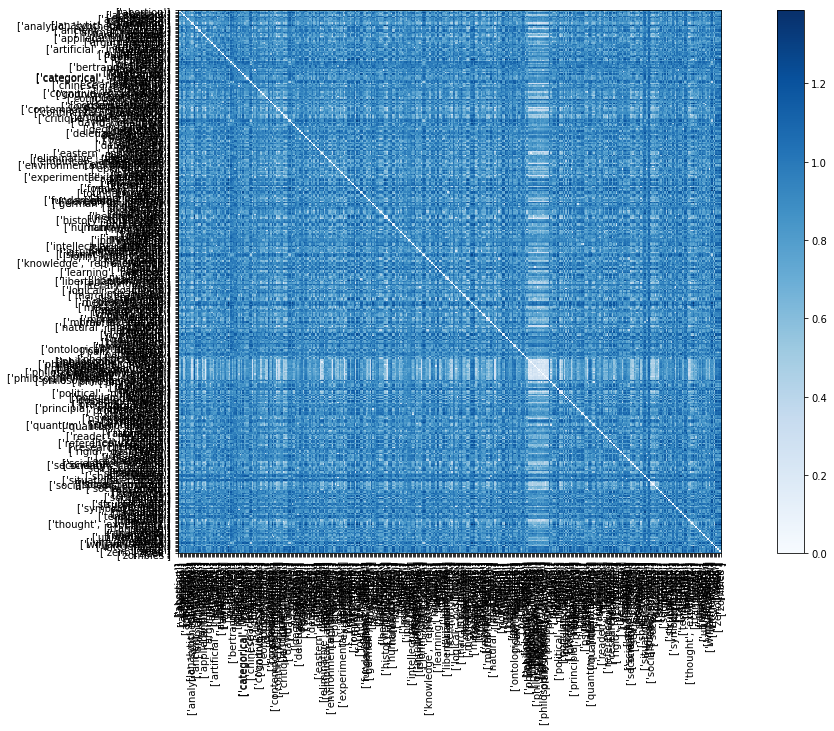

In [266]:
plot_distance_matrix(dist_matrix, tags)

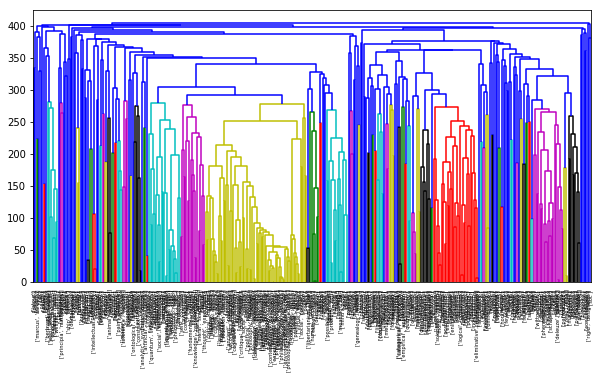

[(0, ['ayn', 'rand']), (0, ['bioethics']), (0, ['bostrom']), (0, ['conciousness']), (0, ['ponty']), (1, ['abstract']), (1, ['absurdism']), (1, ['adorno']), (1, ['agnosticism']), (1, ['altruism']), (1, ['analyticity']), (1, ['anselm']), (1, ['anti', 'realism']), (1, ['aquinas']), (1, ['arendt']), (1, ['argumentation']), (1, ['aristotle']), (1, ['atheism']), (1, ['atomism']), (1, ['badiou']), (1, ['buddhism']), (1, ['camus']), (1, ['capitalism']), (1, ['cassirer']), (1, ['categorical', 'framework']), (1, ['categorical', 'imperative']), (1, ['causality']), (1, ['causation']), (1, ['chomsky']), (1, ['christianity']), (1, ['confucius']), (1, ['consequentialism']), (1, ['constructivism']), (1, ['dawkins']), (1, ['deconstruction']), (1, ['deleuze']), (1, ['deleuze', 'guattari']), (1, ['dennett']), (1, ['deontology']), (1, ['derrida']), (1, ['descartes']), (1, ['determinism']), (1, ['dialectic']), (1, ['dualism']), (1, ['eliminative', 'materialism']), (1, ['empirical', 'apperception']), (1, ['

In [267]:
cl = AgglomerativeClustering(n_clusters=10, linkage='average', affinity='precomputed', )
cl.fit(dist_matrix)
plot_dendrogram(cl, labels=tags)

print(sorted(zip(cl.labels_, tags)))

Apparently, tags are too generic or specific, and the similarity extracted from those is not very useful. One option could be to train a word2vec model on a specific corpus in order to get better vectors. However, collecting data for such a model would probably be very hard, and some terms appear to be so specific that vector representations for those would probably be very poor. So what can we do?

## 2.2 LDA topic modeling for question clustering

The next idea is to use a topic modeling algorithm such as LDA in order to compute the "class" of each question. This could then be used to build a number of corpora, one for each topic, based on this categorization. Given a user's query, the system can then compute the query's topic according to the trained model, thus selecting the best text generator to reply.

In [396]:
# Build a 'Doc' field for questions. Those with an answer (either accepted or most voted) get the concatenation
# of the question's and answer's bodies. The rest just gets the question's body. We keep questions with no answer at all
# as they may still help in training the lda model.
nans = pd.isna(final_df['Id_a'])
corpus_df = final_df.loc[~nans,:]
print('{} unanswered questions found.'.format(len(nans)))
print('{} Total questions used to train the model.'.format(len(corpus_df)))

# final_df['Doc'] = final_df['Body_q']
# final_df.loc[~nans, 'Doc'] += '\n' + final_df.loc[~nans, 'Body_a']

corpus_df = corpus_df.reset_index()

9696 unanswered questions found.
8752 Total questions used to train the model.


## Preprocessing
We next need to preprocess the dataset so we have one "document" per question + answer. For LDA to build the model, documents need to be represented in matrix form, i.e. a document matrix in which each row is the bow of a document. In order to capture the underlying semantic content, the following steps are performed on each document:

* make the text lowercase
* remove stopwords, punctuation, symbols, etc.
* remove urls
* lemmatization
* remove < 3-chars words

In [397]:
import re

from gensim import models, corpora
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk import pos_tag

# list of stopwords which appeared in the trained topics, and which did not add much to the semantic content
custom_stopwords = ['one', 'say', 'also', 'could', 'would', 'should', 'shall']
sw = set(stopwords.words('english')).union(set(custom_stopwords))
stemmer = SnowballStemmer('english')

url_re = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',re.IGNORECASE|re.DOTALL)

def preprocess(text):
    # wordnet lemmatizer requires pos-tags. Courtesy of https://www.kaggle.com/alvations/basic-nlp-with-nltk
    def penn2morphy(penntag):
        """ Converts Penn Treebank tags to WordNet. """
        morphy_tag = {'NN':'n', 'JJ':'a',
                      'VB':'v', 'RB':'r'}
        try:
            return morphy_tag[penntag[:2]]
        except:
            return 'n' # if mapping isn't found, fall back to Noun.
    
    text = text.lower()
    text = url_re.sub('', text) # remove http links
    text = re.sub(r'([a-z0-9])\/([a-z0-9])', r'\1 \2', text) # convert 'a/b' to 'a b'
    text = re.sub('[^a-z\s]', '', text)      # get rid of noise (punctuation, symbols, etc.)
#     text = [lemmatizer.lemmatize(w, pos=penn2morphy(tag)) for w, tag in pos_tag(text.split()) if w not in sw]
    # for some reasons, single letters would end up in a topic (perhaps something to do with logical formulae).
    # Just remove everything below three-chars length
    text = [stemmer.stem(w) for w in text.split() if w not in sw and len(w) > 3]
    
    return text

# Just get the most likely topic for the query according to the model
def get_query_topic(query, lda):
    query_ = lda.id2word.doc2bow(preprocess(query))
    query_topic = np.argmax([score for t,score in lda[query_]])
    return query_topic

def get_query_topics(query, lda):
    query_ = lda.id2word.doc2bow(preprocess(query))
    return lda.get_document_topics(query_)

In [398]:
# print(preprocess('Test1/test2, and a link: https://en.wikipedia.org/MyPage.'))
docs = corpus_df['Body_q'].apply(preprocess)

dictionary = corpora.Dictionary(docs)
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [399]:
rnd = np.random.choice(len(corpus_df))
print([(dictionary[w],f) for w,f in corpus[rnd]])

[('someon', 1), ('sinc', 1), ('logic', 4), ('make', 1), ('theori', 1), ('understand', 2), ('appli', 1), ('correct', 1), ('prove', 1), ('sens', 1), ('work', 1), ('confirm', 1), ('proposit', 3), ('truth', 2), ('valid', 1), ('method', 1), ('perfect', 1), ('mani', 1), ('pleas', 1), ('textbook', 1), ('infinit', 1), ('model', 1), ('construct', 1), ('decid', 2), ('explan', 1), ('tabl', 2), ('undecid', 1), ('formula', 1), ('predic', 1), ('prepar', 1), ('exam', 1), ('struggl', 1)]


In [400]:
load_model = False

num_topics = 10
model_file = 'lda_{}.bin'.format(num_topics)

if not load_model:
    print('Training LDA on {} questions...'.format(len(corpus)))
    lda = models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=20)
    print('Done. Saving model to {}'.format(model_file))
    lda.save('data/{}'.format(model_file))
else:
    lda = models.ldamodel.LdaModel()
    lda.load('data/{}'.format(model_file))

Training LDA on 8752 questions...
Done. Saving model to lda_10.bin


In [401]:
lda.show_topics(num_words=10)

[(0,
  '0.026*"conscious" + 0.026*"belief" + 0.023*"comput" + 0.019*"brain" + 0.016*"mind" + 0.015*"believ" + 0.015*"human" + 0.012*"intellig" + 0.011*"machin" + 0.010*"physic"'),
 (1,
  '0.042*"free" + 0.014*"determin" + 0.013*"random" + 0.009*"coin" + 0.007*"infinit" + 0.007*"choic" + 0.007*"action" + 0.006*"solut" + 0.006*"head" + 0.006*"problem"'),
 (2,
  '0.030*"philosophi" + 0.022*"philosoph" + 0.021*"question" + 0.013*"read" + 0.013*"know" + 0.012*"scienc" + 0.010*"like" + 0.010*"book" + 0.008*"answer" + 0.008*"think"'),
 (3,
  '0.014*"peopl" + 0.012*"person" + 0.011*"human" + 0.009*"right" + 0.007*"like" + 0.007*"life" + 0.006*"think" + 0.006*"live" + 0.006*"societi" + 0.005*"death"'),
 (4,
  '0.020*"socrat" + 0.017*"sentenc" + 0.016*"plato" + 0.016*"love" + 0.010*"translat" + 0.009*"mean" + 0.009*"statement" + 0.009*"opposit" + 0.008*"freedom" + 0.008*"ident"'),
 (5,
  '0.042*"logic" + 0.024*"true" + 0.017*"truth" + 0.017*"statement" + 0.012*"proposit" + 0.011*"fals" + 0.010*"

In [402]:
query = """What's the meaning of life?"""
lda.show_topic(get_query_topic(query, lda))

[('moral', 0.027036961),
 ('good', 0.015897335),
 ('ethic', 0.015015386),
 ('action', 0.012093326),
 ('person', 0.0097745955),
 ('valu', 0.009705096),
 ('peopl', 0.009355788),
 ('reason', 0.009110474),
 ('life', 0.008947207),
 ('mean', 0.008546552)]

In [403]:
query = """What's the purpose of philosphy?"""
lda.show_topic(get_query_topic(query, lda))

[('philosophi', 0.029837439),
 ('philosoph', 0.022097519),
 ('question', 0.02108146),
 ('read', 0.0131573435),
 ('know', 0.012879087),
 ('scienc', 0.011767336),
 ('like', 0.009963446),
 ('book', 0.009708593),
 ('answer', 0.008379292),
 ('think', 0.008013249)]

In [404]:
query = """What's the meaning of life? Is it just a lonely wander until death? Or is there more to it which make it valuable to be lived?"""
lda.show_topic(get_query_topic(query, lda))

[('peopl', 0.013506599),
 ('person', 0.011945279),
 ('human', 0.010551801),
 ('right', 0.009144958),
 ('like', 0.007150948),
 ('life', 0.007006538),
 ('think', 0.006053697),
 ('live', 0.005944699),
 ('societi', 0.0058550313),
 ('death', 0.0052459305)]

In [405]:
query = """Was mathematics invented or discovered?. What would it mean to say that mathematics was invented and how would this be different from saying mathematics was discovered? Is this even a serious philosophical question or just a meaningless/tautological linguistic ambiguity?"""
print(preprocess(query))
lda.show_topic(get_query_topic(query, lda))
lda.get_document_topics(lda.id2word.doc2bow(preprocess(query)))

lda.show_topic(9)

['mathemat', 'invent', 'discov', 'mean', 'mathemat', 'invent', 'differ', 'say', 'mathemat', 'discov', 'even', 'serious', 'philosoph', 'question', 'meaningless', 'tautolog', 'linguist', 'ambigu']


[('exist', 0.025474956),
 ('time', 0.013408678),
 ('thing', 0.012114635),
 ('someth', 0.010066622),
 ('object', 0.009685732),
 ('world', 0.009461051),
 ('physic', 0.009362496),
 ('univers', 0.00931372),
 ('think', 0.008313791),
 ('possibl', 0.007960462)]

Now that we have a model, we can assign each document to the corpus for a specific topic. 

**TODO**: To account for the fact that each document is actually a mixture of topics, scores past the first match could be treated as probabilities, and the document added to the corresponding corpus according to that probability. E.g. `if score(topic_0|doc_0) = 0.5 then add doc_0 to topic_0 corpus with 50% chance`.

In [407]:
corpora_files = [open('data/topics/topic_{}.txt'.format(i), 'w+', encoding='utf-8') for i in range(num_topics)]
for i, doc in enumerate(corpus):
    doc_topics = lda.get_document_topics(doc)
    first_topic = doc_topics[0][0]
    
    # Always add the most relevant topic to the training set 
    corpora_files[first_topic].write(corpus_df.loc[i, 'Body_a'])
    
    # For the rest, pick the document with probability proportional to the topic's weight
#     for doc_topic, score in doc_topics[1:]:
#         if np.random.rand() < score:
#             corpora_files[doc_topic].write(final_df.loc[i, 'Doc'])
        
for file in corpora_files:
    file.close()